In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import Imputer, StandardScaler, OneHotEncoder, PolynomialFeatures, LabelEncoder, MaxAbsScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
import matplotlib.pyplot as plt
import random
import fix_yahoo_finance as yf
from yahoofinancials import YahooFinancials
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

Use freely available data from the web to predict/explain macroeconomic indicators.
Financial/Economic/Fundamentals data are not allowed.

In [5]:
gun_violence = pd.read_csv('/Users/sharontsao/Desktop/yewno_interview/gun-violence-data/stage3.csv')
eff_ffr = pd.read_csv('/Users/sharontsao/Desktop/yewno_interview/IR_csv_2/data/DFF.csv')

In [588]:
eff_ffr = eff_ffr.rename(index=str, columns={"DATE": "date", "VALUE": "eff"})

In [589]:
eff_ffr = eff_ffr[(eff_ffr['date'] > '2012-12-31') & (eff_ffr['date'] < '2018-04-01')]

In [590]:
gun_violence.columns

Index(['incident_id', 'date', 'state', 'city_or_county', 'address', 'n_killed',
       'n_injured', 'incident_url', 'source_url',
       'incident_url_fields_missing', 'congressional_district', 'gun_stolen',
       'gun_type', 'incident_characteristics', 'latitude',
       'location_description', 'longitude', 'n_guns_involved', 'notes',
       'participant_age', 'participant_age_group', 'participant_gender',
       'participant_name', 'participant_relationship', 'participant_status',
       'participant_type', 'sources', 'state_house_district',
       'state_senate_district'],
      dtype='object')

In [591]:
#preprocessing
gun_violence['date'] = pd.to_datetime(gun_violence['date'], format="%Y-%m-%d")
eff_ffr['date'] = pd.to_datetime(eff_ffr['date'], format="%Y-%m-%d")

In [592]:
df = pd.merge(gun_violence, eff_ffr, how = 'right')

Working only with Numerical Data

In [929]:
# numeric data
df_num = df.select_dtypes(exclude = ['object'])
df_nn = df.select_dtypes(include = ['object', 'datetime'])

In [594]:
df_numeric_features = df_num.columns.tolist()

In [595]:
perc_exclude = .03  #Here I'm setting the percentage of missing data I'm allowing
data_count = len(df_num)
feature_count = len(df_num.dtypes)

print('Feature Count: ' + str(feature_count))
print('Number of Data: ' + str(data_count))
structure = [df_num.isnull().sum()/data_count > perc_exclude]
structure = pd.DataFrame(structure)
structure = structure.T
my_col = ['missing_perc']
structure.columns = my_col
exclude_features = list(structure[structure.missing_perc == True].index)
exclude_features.append('incident_id')

print('Number of features using: ' + str(feature_count - len(exclude_features)))

Feature Count: 11
Number of Data: 239868
Number of features using: 4


In [898]:
included_features = [x for x in df_numeric_features if x not in exclude_features]
X_included_features = [x for x in included_features if x not in 'eff']

In [899]:
temp = df.groupby(['date', 'eff'])['n_killed', 'n_injured'].apply(lambda x: x.astype(float).sum())

In [900]:
temp = temp.reset_index().set_index('date')

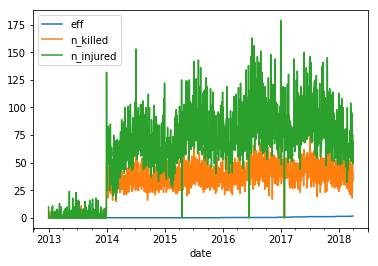

In [901]:
#some visualization
temp.plot()

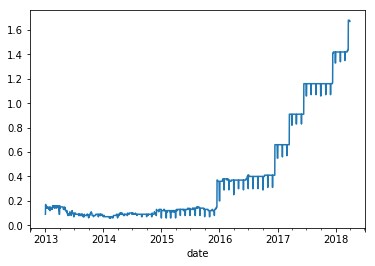

In [902]:
temp.eff.plot()

In [903]:
temp.corr()

,eff,n_killed,n_injured
eff,1.000000,0.400140,0.372779
n_killed,0.400140,1.000000,0.881329
n_injured,0.372779,0.881329,1.000000


In [904]:
from scipy import stats

Text(0.5,1,'R$^2$ = 0.37')

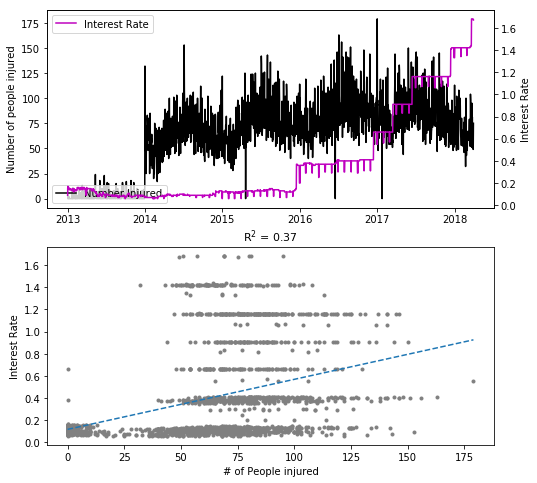

In [905]:
plt.figure(figsize=(8,8))
# plot time-series
ax1 = plt.subplot(2,1,1)
plt.plot(temp.n_injured, 'k', label="Number Injured")
plt.legend(loc=3)
plt.ylabel("Number of people injured")
 
# fit one-factor linear model
slope, intercept, r2_value, p_value, std_err = stats.linregress(temp.n_injured, temp['eff'])
 
# best fit: model
xline = np.linspace(np.min(temp.n_injured), np.max(temp.n_injured), 100)
line = slope*xline + intercept
 
# plot scatter plot and linear model
ax2 = ax1.twinx()
plt.plot(temp['eff'], 'm', label="Interest Rate")
plt.ylabel("Interest Rate")
plt.legend(loc="best")
plt.subplot(2,1,2)
plt.plot(temp.n_injured, temp.eff,'.', color= 'grey')
plt.plot(xline, line,'--')
plt.xlabel("# of People injured")
plt.ylabel("Interest Rate")
plt.title("R$^2$ = %.2f" % r2_value, fontsize=11)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pd.rolling_corr is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20).corr(other=<Series>)
  """Entry point for launching an IPython kernel.


Text(0,0.5,'Linear Correlation ( day rolling window)')

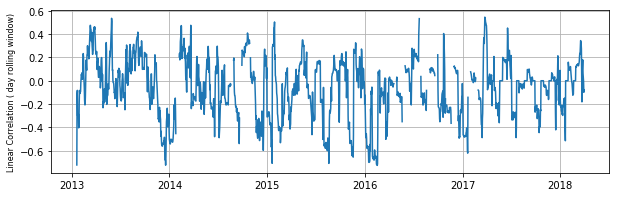

In [906]:
rollcorr = pd.rolling_corr(temp.eff, temp.n_injured,  20).dropna()
 
plt.figure(figsize=(10,3))
plt.plot(rollcorr)
plt.grid()
plt.ylabel("Linear Correlation ( day rolling window)", fontsize=8)

In [907]:
temp[temp == 0] = 0.00001

In [908]:
headers = temp.columns
dlog = pd.DataFrame()  # log returns Dateframe 
 
for j in range(temp.shape[1]):
    price = temp.ix[:,j]
    dl = np.log(price) - np.log(price.shift(1))
    dlog.loc[:,j] = dl
 
dlog.dropna(inplace=True)
dlog.columns = headers
print(dlog.head())

                 eff   n_killed  n_injured
date                                      
2013-01-02  0.635989 -12.206073 -13.815511
2013-01-03  0.000000   0.000000   0.000000
2013-01-04 -0.060625   0.000000   0.000000
2013-01-05  0.000000  12.899220   0.000000
2013-01-06  0.000000 -12.899220   0.000000


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """


Working only with Numerical + Categorical Data

In [919]:
X = temp[['n_killed', 'n_injured']]
y = temp[['eff']]

In [920]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [922]:
#Creating scaler + polynomial object

scaler = StandardScaler()
poly = PolynomialFeatures()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
X_train_scaled_poly = poly.fit_transform(X_train)
X_test_scaled_poly = poly.fit_transform(X_test)

In [923]:
linear = LinearRegression().fit(X_train_scaled_poly, y_train)
scores = cross_val_score(linear, X_train_scaled_poly, y_train, cv = 10)
print('Linear Regression')
print('Train Score: ' + str(np.mean(scores)))
print('Test Score:' + str(linear.score(X_test_scaled_poly, y_test)))

Linear Regression
Train Score: 0.15386453485409116
Test Score:0.1411710942961636


I was a little bit curious to see if gun related crime is somehow linked to changes in interest rate. The idea is that maybe the change in federal fund rates affects some people's finances, which triggers these events. 

In [924]:
#Ridge Regression
train_scores = []
test_scores = []

param_grid = {'alpha': np.logspace(-3, 3, 13)}
grid = GridSearchCV(Ridge(random_state=0), param_grid=param_grid, cv=10)
grid.fit(X_train_scaled_poly, y_train)

train_scores.append(grid.score(X_train_scaled_poly, y_train))
test_scores.append(grid.score(X_test_scaled_poly, y_test))

print('\n')
print('Ridge Regression')
print(grid.best_params_)
print('Average Train Scores: ' + str(np.mean(train_scores)))
print('Average Test Scores: ' + str(np.mean(test_scores)))



Ridge Regression
{'alpha': 1000.0}
Average Train Scores: 0.17483621707782646
Average Test Scores: 0.14152198773714975


In [930]:
# adding categorical data

df_cat_features = df_nn.columns.tolist()
perc_exclude = .1  #Here I'm setting the percentage of missing data I'm allowing
data_count = len(df_nn)
feature_count = len(df_nn.dtypes)


print('Feature Count: ' + str(feature_count))
print('Number of Data: ' + str(data_count))
structure = [df_nn.isnull().sum()/data_count > perc_exclude]
structure = pd.DataFrame(structure)
structure = structure.T
my_col = ['missing_perc']
structure.columns = my_col
exclude_features_nn = list(structure[structure.missing_perc == True].index)

include_features_nn = [x for x in df_nn.columns if x not in exclude_features_nn]
print('Number of categorical features using: ' + str(len(include_features_nn)))

Feature Count: 20
Number of Data: 239868
Number of categorical features using: 9


In [931]:
df_nn

,date,state,city_or_county,address,incident_url,source_url,incident_url_fields_missing,gun_stolen,gun_type,incident_characteristics,location_description,notes,participant_age,participant_age_group,participant_gender,participant_name,participant_relationship,participant_status,participant_type,sources
0,2013-01-01,Pennsylvania,Mckeesport,1506 Versailles Avenue and Coursin Street,http://www.gunviolencearchive.org/incident/461105,http://www.post-gazette.com/local/south/2013/0...,False,NaN,NaN,Shot - Wounded/Injured||Mass Shooting (4+ vict...,NaN,Julian Sims under investigation: Four Shot and...,0::20,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||3::Male||4::Female,0::Julian Sims,NaN,0::Arrested||1::Injured||2::Injured||3::Injure...,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://pittsburgh.cbslocal.com/2013/01/01/4-pe...
1,2013-01-01,California,Hawthorne,13500 block of Cerise Avenue,http://www.gunviolencearchive.org/incident/460726,http://www.dailybulletin.com/article/zz/201301...,False,NaN,NaN,"Shot - Wounded/Injured||Shot - Dead (murder, a...",NaN,Four Shot; One Killed; Unidentified shooter in...,0::20,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male,0::Bernard Gillis,NaN,0::Killed||1::Injured||2::Injured||3::Injured,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://losangeles.cbslocal.com/2013/01/01/man-...
2,2013-01-01,Ohio,Lorain,1776 East 28th Street,http://www.gunviolencearchive.org/incident/478855,http://chronicle.northcoastnow.com/2013/02/14/...,False,0::Unknown||1::Unknown,0::Unknown||1::Unknown,"Shot - Wounded/Injured||Shot - Dead (murder, a...",Cotton Club,NaN,0::25||1::31||2::33||3::34||4::33,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||2::Male||3::Male||4::Male,0::Damien Bell||1::Desmen Noble||2::Herman Sea...,NaN,"0::Injured, Unharmed, Arrested||1::Unharmed, A...",0::Subject-Suspect||1::Subject-Suspect||2::Vic...,http://www.morningjournal.com/general-news/201...
3,2013-01-05,Colorado,Aurora,16000 block of East Ithaca Place,http://www.gunviolencearchive.org/incident/478925,http://www.dailydemocrat.com/20130106/aurora-s...,False,NaN,NaN,"Shot - Dead (murder, accidental, suicide)||Off...",NaN,NaN,0::29||1::33||2::56||3::33,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Female||1::Male||2::Male||3::Male,0::Stacie Philbrook||1::Christopher Ratliffe||...,NaN,0::Killed||1::Killed||2::Killed||3::Killed,0::Victim||1::Victim||2::Victim||3::Subject-Su...,http://denver.cbslocal.com/2013/01/06/officer-...
4,2013-01-07,North Carolina,Greensboro,307 Mourning Dove Terrace,http://www.gunviolencearchive.org/incident/478959,http://www.journalnow.com/news/local/article_d...,False,0::Unknown||1::Unknown,0::Handgun||1::Handgun,"Shot - Wounded/Injured||Shot - Dead (murder, a...",NaN,Two firearms recovered. (Attempted) murder sui...,0::18||1::46||2::14||3::47,0::Adult 18+||1::Adult 18+||2::Teen 12-17||3::...,0::Female||1::Male||2::Male||3::Female,0::Danielle Imani Jameison||1::Maurice Eugene ...,3::Family,0::Injured||1::Injured||2::Killed||3::Killed,0::Victim||1::Victim||2::Victim||3::Subject-Su...,http://myfox8.com/2013/01/08/update-mother-sho...
5,2013-01-07,Oklahoma,Tulsa,6000 block of South Owasso,http://www.gunviolencearchive.org/incident/478948,http://usnews.nbcnews.com/_news/2013/01/07/163...,False,NaN,NaN,"Shot - Dead (murder, accidental, suicide)||Hom...",Fairmont Terrace,NaN,0::23||1::23||2::33||3::55,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Female||1::Female||2::Female||3::Female||4:...,0::Rebeika Powell||1::Kayetie Melchor||2::Mist...,NaN,0::Killed||1::Killed||2::Killed||3::Killed||4:...,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://www.kjrh.com/news/local-news/4-found-sh...
6,2013-01-19,New Mexico,Albuquerque,2806 Long Lane,http://www.gunviolencearchive.org/incident/479363,http://hinterlandgazette.com/2013/01/pastor-gr...,False,0::Unknown||1::Unknown,0::22 LR||1::223 Rem [AR-15],"Shot - Dead (murder, accidental, suicide)||Mas...

In [936]:
df_nn = df_nn.reset_index().set_index('date')

In [939]:
include_features_nn = ['incident_characteristics']

In [940]:
X_cat = df_nn[include_features_nn]
dummies = pd.get_dummies(X_cat['incident_characteristics'])
atom_col = [c for c in dummies.columns if '|' not in c]
for col in atom_col:
    X_cat[col] = dummies[[c for c in dummies.columns if col in c]].sum(axis=1)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [945]:
X_cat = X_cat.drop(columns = ['incident_characteristics'])
X_cat = X_cat.groupby(X_cat.index)[X_cat.columns].apply(lambda x: x.astype(float).sum())

In [947]:
# all cat and numerical data together
X = pd.merge(X_cat, temp[['n_killed', 'n_injured']],left_index=True, right_index=True )

In [951]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [959]:
train_scores = []
test_scores = []

param_grid = {'max_depth':range(1, 15)}
grid = GridSearchCV(RandomForestRegressor(random_state=0), param_grid=param_grid, cv=10)
grid.fit(X_train, y_train)

train_scores.append(grid.score(X_train, y_train))
test_scores.append(grid.score(X_test, y_test))

print(grid.best_params_)
print('Average RF Train Scores: ' + str(np.mean(train_scores)))
print('Average RF Test Scores: ' + str(np.mean(test_scores)))

{'max_depth': 9}
Average RF Train Scores: 0.9684614041833075
Average RF Test Scores: 0.853501386040204


In [960]:
grid

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': range(1, 15)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0)

After I've included categorical data into the numerical data, random forest seem to work much metter in explaining interest rate. 

#### Implement one Smart Beta strategy and discuss pros and cons compared to a chosen benchmark.

In [349]:
start = '2018-07-01'
end = '2018-09-30'

In [363]:
SPlist = ['MMM', 'ABT', 'ABBV', 'ABMD','ACN','ATVI','ADBE','AMD',
'AAP',
'AES',
'AET',
'AMG',
'AFL',
'A',
'APD',
'AKAM',
'ALK',
'ALB',
'ARE',
'ALXN',
'ALGN',
'ALLE',
'AGN',
'ADS',
'LNT',
'ALL',
'GOOGL',
'GOOG',
'MO',
'AMZN',
'AEE',
'AAL',
'AEP',
'AXP',
'AIG',
'AMT',
'AWK',
'AMP',
'ABC',
'AME',
'AMGN',
'APH',
'APC',
'ADI',
'ANSS',
'ANTM',
'AON',
'AOS',
'APA',
'AIV',
'AAPL',
'AMAT',
'APTV',
'ADM',
'ARNC',
'ANET',
'AJG',
'AIZ',
'T',
'ADSK',
'ADP',
'AZO',
'AVB',
'AVY',
'BHGE',
'BLL',
'BAC',
'BK',
'BAX',
'BBT',
'BDX',
'BRK.B',
'BBY',
'BIIB',
'BLK',
'HRB',
'BA',
'BKNG',
'BWA',
'BXP',
'BSX',
'BHF',
'BMY',
'AVGO',
'BR',
'BF.B',
'CHRW',
'CA',
'COG',
'CDNS',
'CPB',
'COF',
'CAH',
'KMX',
'CCL',
'CAT',
'CBOE',
'CBRE',
'CBS',
'CELG',
'CNC',
'CNP',
'CTL',
'CERN',
'CF',
'SCHW',
'CHTR',
'CVX',
'CMG',
'CB',
'CHD',
'CI',
'XEC',
'CINF',
'CTAS',
'CSCO',
'C',
'CFG',
'CTXS',
'CLX',
'CME',
'CMS',
'KO',
'CTSH',
'CL',
'CMCSA',
'CMA',
'CAG',
'CXO',
'COP',
'ED',
'STZ',
'COO',
'CPRT',
'GLW',
'COST',
'COTY',
'CCI',
'CSX',
'CMI',
'CVS',
'DHI',
'DHR',
'DRI',
'DVA',
'DE',
'DAL',
'XRAY',
'DVN',
'DLR',
'DFS',
'DISCA',
'DISCK',
'DISH',
'DG',
'DLTR',
'D',
'DOV',
'DWDP',
'DTE',
'DRE',
'DUK',
'DXC',
'ETFC',
'EMN',
'ETN',
'EBAY',
'ECL',
'EIX',
'EW',
'EA',
'EMR',
'ETR',
'EVHC',
'EOG',
'EQT',
'EFX',
'EQIX',
'EQR',
'ESS',
'EL',
'EVRG',
'ES',
'RE',
'EXC',
'EXPE',
'EXPD',
'ESRX',
'EXR',
'XOM',
'FFIV',
'FB',
'FAST',
'FRT',
'FDX',
'FIS',
'FITB',
'FE',
'FISV',
'FLT',
'FLIR',
'FLS',
'FLR',
'FMC',
'FL',
'F',
'FTV',
'FBHS',
'BEN',
'FCX',
'GPS',
'GRMN',
'IT',
'GD',
'GE',
'GIS',
'GM',
'GPC',
'GILD',
'GPN',
'GS',
'GT',
'GWW',
'HAL',
'HBI',
'HOG',
'HRS',
'HIG',
'HAS',
'HCA',
'HCP',
'HP',
'HSIC',
'HSY',
'HES',
'HPE',
'HLT',
'HFC',
'HOLX',
'HD',
'HON',
'HRL',
'HST',
'HPQ',
'HUM',
'HBAN',
'HII',
'IDXX',
'INFO',
'ITW',
'ILMN',
'IR',
'INTC',
'ICE',
'IBM',
'INCY',
'IP',
'IPG',
'IFF',
'INTU',
'ISRG',
'IVZ',
'IPGP',
'IQV',
'IRM',
'JEC',
'JBHT',
'JEF',
'SJM',
'JNJ',
'JCI',
'JPM',
'JNPR',
'KSU',
'K',
'KEY',
'KMB',
'KIM',
'KMI',
'KLAC',
'KSS',
'KHC',
'KR',
'LB',
'LLL',
'LH',
'LRCX',
'LEG',
'LEN',
'LLY',
'LNC',
'LKQ',
'LMT',
'L',
'LOW',
'LYB',
'MTB',
'MAC',
'M',
'MRO',
'MPC',
'MAR',
'MMC',
'MLM',
'MAS',
'MA',
'MAT',
'MKC',
'MCD',
'MCK',
'MDT',
'MRK',
'MET',
'MTD',
'MGM',
'KORS',
'MCHP',
'MU',
'MSFT',
'MAA',
'MHK',
'TAP',
'MDLZ',
'MNST',
'MCO',
'MS',
'MOS',
'MSI',
'MSCI',
'MYL',
'NDAQ',
'NOV',
'NKTR',
'NTAP',
'NFLX',
'NWL',
'NFX',
'NEM',
'NWSA',
'NWS',
'NEE',
'NLSN',
'NKE',
'NI',
'NBL',
'JWN',
'NSC',
'NTRS',
'NOC',
'NCLH',
'NRG',
'NUE',
'NVDA',
'ORLY',
'OXY',
'OMC',
'OKE',
'ORCL',
'PCAR',
'PKG',
'PH',
'PAYX',
'PYPL',
'PNR',
'PBCT',
'PEP',
'PKI',
'PRGO',
'PFE',
'PCG',
'PM',
'PSX',
'PNW',
'PXD',
'PNC',
'RL',
'PPG',
'PPL',
'PX',
'PFG',
'PG',
'PGR',
'PLD',
'PRU',
'PEG',
'PSA',
'PHM',
'PVH',
'QRVO',
'PWR',
'QCOM',
'DGX',
'RJF',
'RTN',
'O',
'RHT',
'REG',
'REGN',
'RF',
'RSG',
'RMD',
'RHI',
'ROK',
'COL',
'ROL',
'ROP',
'ROST',
'RCL',
'CRM',
'SBAC',
'SCG',
'SLB',
'STX',
'SEE',
'SRE',
'SHW',
'SPG',
'SWKS',
'SLG',
'SNA',
'SO',
'LUV',
'SPGI',
'SWK',
'SBUX',
'STT',
'SRCL',
'SYK',
'STI',
'SIVB',
'SYMC',
'SYF',
'SNPS',
'SYY',
'TROW',
'TTWO',
'TPR',
'TGT',
'TEL',
'FTI',
'TXN',
'TXT',
'TMO',
'TIF',
'TWTR',
'TJX',
'TMK',
'TSS',
'TSCO',
'TDG',
'TRV',
'TRIP',
'FOXA',
'FOX',
'TSN',
'UDR',
'ULTA',
'USB',
'UAA',
'UA',
'UNP',
'UAL',
'UNH',
'UPS',
'URI',
'UTX',
'UHS',
'UNM',
'VFC',
'VLO',
'VAR',
'VTR',
'VRSN',
'VRSK',
'VZ',
'VRTX',
'VIAB',
'V',
'VNO',
'VMC',
'WMT',
'WBA',
'DIS',
'WM',
'WAT',
'WEC',
'WCG',
'WFC',
'WELL',
'WDC',
'WU',
'WRK',
'WY',
'WHR',
'WMB',
'WLTW',
'WYNN',
'XEL',
'XRX',
'XLNX',
'XYL',
'YUM',
'ZBH',
'ZION']

In [389]:
data = yf.download(SPlist[0], start, end)
data = data.rename(columns={ data.columns[4]: SPlist[0] })
data = data[[SPlist[0]]]

[*********************100%***********************]  1 of 1 downloaded


In [390]:
for i in range(1, 500):
    try:
        temp = yf.download(SPlist[i], start, end)
        temp = temp.rename(columns={temp.columns[4]: SPlist[i] })
        temp = temp[[SPlist[i]]]
        data = pd.merge(data, temp, how = 'inner', left_index = True, right_index = True)
    except ValueError:
        pass

[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*******************

[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*******************

[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*******************

In [414]:
corr_matrix = data.corr().abs()
corr_matrix

,MMM,ABT,ABBV,ABMD,ACN,ATVI,ADBE,AMD,AAP,AES,...,WU,WRK,WY,WHR,WMB,WLTW,WYNN,XEL,XRX,XLNX
MMM,1.000000,0.826824,0.081507,0.115354,0.566584,0.104409,0.661665,0.842970,0.798202,0.585667,...,0.595423,0.406030,0.714664,0.710477,0.120792,0.543759,0.643388,0.617988,0.841847,0.924156
ABT,0.826824,1.000000,0.083794,0.218150,0.621447,0.347777,0.762935,0.872727,0.793118,0.588950,...,0.549341,0.599380,0.789250,0.724219,0.065233,0.652333,0.707071,0.417148,0.742102,0.874436
ABBV,0.081507,0.083794,1.000000,0.242304,0.139590,0.434980,0.101398,0.045904,0.128145,0.317587,...,0.353659,0.273283,0.235550,0.071250,0.254326,0.335231,0.153273,0.339976,0.196844,0.027570
ABMD,0.115354,0.218150,0.242304,1.000000,0.479618,0.720104,0.390158,0.060064,0.025812,0.357745,...,0.319557,0.044364,0.082253,0.321215,0.656847,0.057404,0.088989,0.447002,0.251011,0.070292
ACN,0.566584,0.621447,0.139590,0.479618,1.000000,0.684041,0.776028,0.744343,0.677407,0.108637,...,0.284357,0.159805,0.175198,0.190641,0.578736,0.381920,0.514941,0.304884,0.548087,0.570001
ATVI,0.104409,0.347777,0.434980,0.720104,0.684041,1.000000,0.534241,0.303911,0.081892,0.326189,...,0.341865,0.174667,0.002443,0.217236,0.790611,0.085892,0.024830,0.315903,0.056020,0.077738
ADBE,0.661665,0.762935,0.101398,0.390158,0.776028,0.534241,1.000000,0.788621,0.708612,0.306178,...,0.448916,0.389845,0.534819,0.474802,0.172478,0.467434,0.547783,0.402894,0.653844,0.731674
AMD,0.842970,0.872727,0.045904,0.060064,0.744343,0.303911,0.788621,1.000000,0.920330,0.507003,...,0.688901,0.564813,0.651022,0.694739,0.127861,0.754348,0.866519,0.678622,0.854759,0.917299
AAP,0.798202,0.793118,0.128145,0.025812,0.677407,0.081892,0.708612,0.920330,1.000000,0.618623,...,0.817041,0.627260,0.588828,0.722070,0.027394,0.801332,0.891001,0.769834,0.918521,0.885576
AES,0.585667,0.588950,0.317587,0.357745,0.108637,0.326189,0.306178,0.507003,0.618623,1.000000,...,0.750268,0.560674,0.605742,0.746629,0.524932,0.683697,0.605650,0.603644,0.738309,0.638620


In [429]:
data_adj.shape

(57, 498)

In [746]:
data_adj = data - data.loc['2018-07-02'].values.squeeze()

In [747]:
#percent return compared to 7/2/18
data_percreturn = data_adj*100/data.loc['2018-07-02'].values.squeeze()

In [748]:
# summary of all of the stocks
summary = data_percreturn.describe().T
summary['mean/std'] = summary['mean'] / summary['std']
summary.sort_values('mean/std', ascending=False)#.head(20)

,count,mean,std,min,25%,50%,75%,max,mean/std
BIIB,57.0,16.459628,4.915914,-0.764100,15.197624,16.556785,18.369009,29.773135,3.348233
CA,57.0,19.267176,6.787657,-0.663904,20.885201,21.853387,22.206877,22.846861,2.838561
IDXX,57.0,9.457019,3.375344,-1.111710,8.717466,9.788505,11.221078,14.994581,2.801795
FAST,57.0,18.761970,6.739901,-0.645830,18.023696,21.044572,22.429137,27.694677,2.783716
CB,57.0,6.743363,2.438078,0.000000,5.283494,6.647744,8.540340,10.979569,2.765852
ORCL,57.0,8.369935,3.297745,-0.511677,7.226494,8.276206,9.258907,15.512490,2.538078
HUM,57.0,8.519418,3.370991,0.000000,5.947124,8.507368,11.475902,13.992633,2.527274
CELG,57.0,10.824411,4.287440,-1.081625,7.973835,11.055214,13.658660,18.790083,2.524679
KO,57.0,4.622930,1.845492,0.000000,3.108571,5.325723,5.944994,7.512501,2.504985
KMI,57.0,3.271984,1.315860,0.000000,2.467014,3.212845,4.147018,6.177728,2.486574


In [749]:
cov_matrix = data_percreturn.cov()

In [837]:
num_port = 100000
results = np.zeros((3, num_port))
best_weights = []
best_ratio = 0


for i in range(0, num_port):
    
    stock_pick = random.sample(range(498), 20)
    
    temp = data_percreturn.iloc[:, stock_pick]
    mean_daily = temp.mean()
    cov_matrix = temp.cov()

    
    weights = np.random.random(20)
    weights /= np.sum(weights)
    
    # calculate ret and vol
    portfolio_return = np.sum(mean_daily * weights) * 57
    portfolio_std_dev = np.sqrt(np.dot(weights.T,np.dot(cov_matrix, weights))) * np.sqrt(57)
    
    #store results in results array
    results[0,i] = portfolio_return
    results[1,i] = portfolio_std_dev
    #store Sharpe Ratio (return / volatility) - risk free rate element excluded for simplicity
    results[2,i] = results[0,i] / results[1,i]

    if results[2,i] > best_ratio:
        best_ratio = results[2,i]
        best_weights = weights
        best_picks = temp.columns
    
#convert results array to Pandas DataFrame
results_frame = pd.DataFrame(results.T,columns=['ret','stdev','sharpe'])

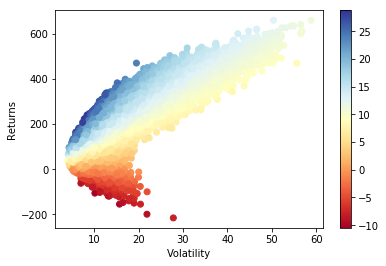

In [838]:
plt.scatter(results_frame.stdev, results_frame.ret, c=results_frame.sharpe, cmap='RdYlBu')
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.colorbar()

In [839]:
print('best stock pick: ' + str(best_picks))
print('best ratio:' + str(best_ratio))
print('best weights:' + str(best_weights))

best stock pick: Index(['CPRT', 'ADS', 'WELL', 'DGX', 'SEE', 'QRVO', 'CHTR', 'BIIB', 'ALXN',
       'CMG', 'RCL', 'ITW', 'KIM', 'ESS', 'KLAC', 'NOC', 'TIF', 'TDG', 'ES',
       'NEE'],
      dtype='object')
best ratio:28.7599107819373
best weights:[0.01778294 0.0452509  0.10235726 0.01900892 0.00356977 0.02723232
 0.009094   0.07498702 0.08159457 0.10611964 0.02584808 0.02826558
 0.05028431 0.03810731 0.06081539 0.03330328 0.08938572 0.06681319
 0.00207135 0.11810844]


I've picked all of the adjusted closing prices of almost all stocks (excluding 2) of the S%P 500, and find the best weights combination of 20 stocks from the S&P 500. I don't know what the best 20 stocks are, and I don't know what are the best combination of weights are. To figure this out, I randomly choose 20 stocks, assign weights, and run this 50K times. The best result is shown above. 

#### a) Suggest one data source that might be useful to explain or predict the FX market.


In [794]:
start = '2010-01-01'
end = '2018-09-30'

In [795]:
us_treasuries = ['^TNX', '^IRX', '^TYX', '^FVX']
currencies = ['EURUSD=X', 'JPY=X', 'GBPUSD=X']

In [796]:
yahoo_financials_treasuries = YahooFinancials(us_treasuries)
yahoo_financials_currencies = YahooFinancials(currencies)

In [797]:
daily_treasury_prices = yahoo_financials_treasuries.get_historical_price_data(start, end, 'daily')
daily_currency_prices = yahoo_financials_currencies.get_historical_price_data(start, end, 'daily')

/usr/local/lib/python3.6/site-packages/yahoofinancials/__init__.py:295: DeprecationWarning: UrlOpener style of invoking requests is deprecated. Use newer urlopen functions/methods
  urlopener = UrlOpener()


In [798]:
#creating dataframe
currency = pd.DataFrame.from_dict(daily_currency_prices[currencies[2]]['prices'])[['formatted_date', 'adjclose']]
currency = currency.rename(index=str, columns={"adjclose": currencies[2]})

In [799]:
#creating dataframe
treasury = pd.DataFrame.from_dict(daily_treasury_prices[us_treasuries[0]]['prices'])[['formatted_date', 'adjclose']]
treasury = treasury.rename(index=str, columns={"adjclose": us_treasuries[0]})

In [800]:
#merging all treasury tables
for i in range(1, 4):
    temp = pd.DataFrame.from_dict(daily_treasury_prices[us_treasuries[i]]['prices'])[['formatted_date', 'adjclose']]
    temp = temp.rename(index=str, columns={"adjclose": us_treasuries[i]})
    treasury = pd.merge(treasury, temp)

In [801]:
#merge treasury and currency
currency_table = pd.merge(currency, treasury)

In [802]:
currencies[2]

'GBPUSD=X'

Text(0,0.5,'Rate')

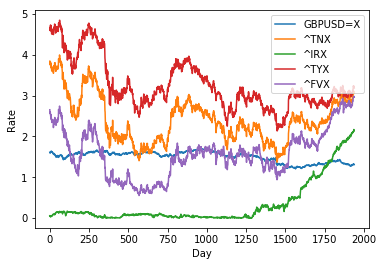

In [810]:
# some visualization
currency_table.plot()
plt.xlabel('Day')
plt.ylabel('Rate')

#### b) Derive and discuss relevant analytics from this data source.


In [811]:
currency_table = currency_table.dropna()

In [812]:
X = currency_table[us_treasuries]
y = currency_table[[currencies[2]]]

In [813]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [818]:
scaler = StandardScaler()
poly = PolynomialFeatures()
X_train_scaled_ = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
X_train_scaled_poly = poly.fit_transform(X_train)
X_test_scaled_poly = poly.fit_transform(X_test)

In [821]:
#Creating scaler and imputation objects

linear = LinearRegression().fit(X_train_scaled_poly, y_train)
scores = cross_val_score(linear, X_train_scaled_poly, y_train, cv = 10)
print('Linear Regression')
print('Train Score: ' + str(np.mean(scores)))
print('Test Score:' + str(linear.score(X_test_scaled_poly, y_test)))

Linear Regression
Train Score: 0.8010761680410212
Test Score:0.8105955807301117


In [816]:
X_train.columns

Index(['^TNX', '^IRX', '^TYX', '^FVX'], dtype='object')

In [817]:
linear.coef_

array([[ 0.36483494, -0.0405253 , -0.18552977, -0.23405769]])

#### c) Determine whether your proposed analytics are co-integrated with currency pairs.



There is definitely a relationship between the four bonds yields to GBPUSD, and the strength of the relationship is described above by the coefficients. 

#### d) Describe and implement a pairs trading strategy exploiting your analytics.

If I had more time, I would take a closer look into events that affect changes in interest rates (which affects the bond yields), and see how each announcement affects GBPUSD. We learn the pattern of the effect and how drastic the changes are in the fx market, and in the future make prediction on the price level of the fx market. 